<a href="https://colab.research.google.com/github/ludovicolanni/neural-music-composer/blob/master/DataExtractionTransformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Extraction and Transformation

This notebook consists in the following steps:
<ol>
<li> Download MIDI files from the MAESTRO datatset
<li> Select a subset of the MAESTRO dataset
<li> Parsed MIDI files into a piano-roll format
<li> Encode MIDI files in a textual representation
</ol>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pretty_midi

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
os.listdir()

['.ipynb_checkpoints',
 '2004',
 '2006',
 '2008',
 '2009',
 '2011',
 '2013',
 '2014',
 '2015',
 '2017',
 '2018',
 'DataPreparation.ipynb',
 'LICENSE',
 'maestro-v2.0.0.csv',
 'maestro-v2.0.0.json',
 'MaestroMetadataExploration.ipynb',
 'README']

In [ ]:
mcsv = pd.read_csv('maestro-v2.0.0.csv')

In [ ]:
#select only the tracks with duration between 2 and 3 minutes

mcsv_short = mcsv[(mcsv.duration>120) & (mcsv.duration<180)]

In [ ]:
print('total duration (hours) of short dataset version: ',(mcsv_short.duration.sum())/3600)

total duration (hours) of short dataset version:  4.053159927290833


In [ ]:
print('number of tracks in short dataset version: ', mcsv_short.shape[0])

number of tracks in short dataset version:  99


In [ ]:
print('split details in short version dataset:')

pd.DataFrame(data=mcsv_short.split.value_counts(), 
             index=['train','test','validation'])

split details in short version dataset:


,split
train,68
test,20
validation,11


In [ ]:
# let's try to load all midi files cited in specific version of mcsv data frame into a dictionary

def load_midi(df):
    
    d = {}
    d['file_names']=[]  # name of midi file as in the data frame
    d['splits']=[]      # suggested split category 
    d['songs']=[]       # midi file parsed using a certain library
    
    for _,track in df.iterrows():
        
        #open correct folder and file
        path = track.midi_filename
        
        #parse it with a midi library
        pm = pretty_midi.PrettyMIDI(path)
        
        #edit the file_names list in d
        d['file_names'].append(track.midi_filename)
        #edit the splits list in d
        d['splits'].append(track.split)
        #edit the songs list in d
        d['songs'].append(pm)
        
    return d     

In [ ]:
#let's call the function and create the music dictionary

music = load_midi(mcsv_short)

In [ ]:
pd.DataFrame(music).head()

,file_names,splits,songs
0,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,test,<pretty_midi.pretty_midi.PrettyMIDI object at ...
1,2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MI...,test,<pretty_midi.pretty_midi.PrettyMIDI object at ...
2,2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MI...,validation,<pretty_midi.pretty_midi.PrettyMIDI object at ...
3,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,validation,<pretty_midi.pretty_midi.PrettyMIDI object at ...
4,2008/MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MI...,train,<pretty_midi.pretty_midi.PrettyMIDI object at ...


In [ ]:
#adding a dictionary key for the list of piano-roll matrices at 8 frames-per-second resolution

music['pianoroll']=[song.instruments[0].get_piano_roll(fs=8) for song in music['songs']]

In [ ]:
#check the 1st dimension of the pianoroll matrix: number of pitches

set([x.shape[0] for x in music['pianoroll']])

{128}

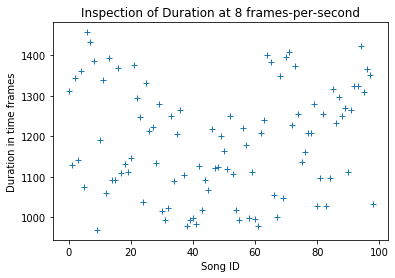

In [ ]:
#check the 2nd dimension of the pianoroll matrix: number of time frames

plt.figure()
plt.plot([x.shape[1] for x in music['pianoroll']],'+')
plt.xlabel('Song ID')
plt.ylabel('Duration in time frames')
plt.title('Inspection of Duration at 8 frames-per-second')
plt.show()

In [ ]:
# try to convert a column of the matrix to a text string

c=136    # test column number -> full

test_pr = music['pianoroll'][0]      # test piano roll matrix

test_column = test_pr[:,c]       # test column

pitches = np.argwhere(test_column!=0).flatten()
velocities = test_column[np.argwhere(test_column!=0)].flatten()

s=''
i=0

while i < len(pitches):
    
    if i != len(pitches)-1:
        s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i])) + '|'
        
    else:
        s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i]))
    
    i = i+1
    
print(s)

In [ ]:
# try to convert a column of the matrix to a text string with support for empty time steps

c=2    # test column number -> empty

test_pr = music['pianoroll'][0]      # test piano roll matrix

test_column = test_pr[:,c]       # test column

pitches = np.argwhere(test_column!=0).flatten()
velocities = test_column[np.argwhere(test_column!=0)].flatten()

if len(pitches)==0:
    
    s='e'

else:
    
    s=''
    i=0
    
    while i < len(pitches):
        
        if i != len(pitches)-1:
            s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i])) + '|'
            
        else:
            s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i]))
        
        i = i+1
    
print(s)

e


In [ ]:
# try to convert each column of the matrix to a list of text strings


test_pr = music['pianoroll'][0]      # test piano roll matrix

n = test_pr.shape[1]

t = []

for c in range(n):         # loop over the columns of the matrix

    test_column = test_pr[:,c]       # test column c
    
    pitches = np.argwhere(test_column!=0).flatten()
    velocities = test_column[np.argwhere(test_column!=0)].flatten()
    
    if len(pitches)==0:
        
        s='e'
    
    else:
        
        s=''
        i=0
        
        while i < len(pitches):
            
            if i != len(pitches)-1:
                s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i])) + '|'
                
            else:
                s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i]))
            
            i = i+1
        
    t.append(s)
    
print(t[:20])
print('length of the list: ', len(t))
print('number of columns in the matrix (number of timesteps): ', n)

['e', 'e', 'e', 'e', 'e', 'e', 'e', 'A4-40', 'A#3-20|E4-34|A4-40', 'A#3-20|E4-34|A4-40', 'A#3-20|E4-34|A4-40', 'A#3-20|E4-34|A4-40', 'A#3-20|E4-34|A4-40', 'A#3-20|E4-34|A4-40|E5-43|F#5-55', 'A#3-20|E4-34|A4-40|E5-43|F#5-55|A5-52', 'A#3-20|E4-34|A4-40|E5-43|F#5-55|A5-52|C6-61', 'A#3-20|E4-34|A4-40|C6-61', 'A#3-20|E4-34|A4-40|C6-61', 'A#3-20|E4-34|A4-40|C6-61', 'A#3-20|E4-34|A4-40|C6-61']
length of the list:  1311
number of columns in the matrix (number of timesteps):  1311


In [ ]:
# At this point we managed to convert a piano-roll matrix 
# into a list of strings with length equal to the number of timesteps in the piano roll.

In [ ]:
# try to convert the entire set of piano-roll matrices into a list of lists of text strings

l = len(music['pianoroll'])
p = []

for x in range(l):      # loop over the pianoroll matrices

    test_pr = music['pianoroll'][x]      # test piano roll matrix
    
    n = test_pr.shape[1]
    
    t = []
    
    for c in range(n):         # loop over the columns of the matrix
    
        test_column = test_pr[:,c]       # test column c
        
        pitches = np.argwhere(test_column!=0).flatten()
        velocities = test_column[np.argwhere(test_column!=0)].flatten()
        
        if len(pitches)==0:
            
            s='e'
        
        else:
            
            s=''
            i=0
            
            while i < len(pitches):
                
                if i != len(pitches)-1:
                    s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i])) + '|'
                    
                else:
                    s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i]))
                
                i = i+1
            
        t.append(s)
    
    p.append(t)
        

print('length of the full list of songs: ', len(p))
print('number of songs in the dataset: ', l)

length of the full list of songs:  99
number of songs in the dataset:  99


In [ ]:
# encapsulate the above process in a function that outputs a single text string for each song.

def from_pianoroll_to_text(data):
    
    '''This function converts a MIDI pianoroll dataset (in the form of a list of 2D numpy arrays) into a text representation (in the form of a list of strings). It returns a list of n strings of variable length m, where n is the number of songs and m is proportional to the number of timesteps in a specific song.
    Each timestep in a song string is separated by a blank space and the code for a single timestep is of type 'NOTE_NAME-VELOCITY|NOTE_NAME-VELOCITY|...'. Where no notes are played in a certain timestep, the corresponding empty character is encoded as e. '''


    l = len(data)
    p = []
    
    for x in range(l):      # loop over the pianoroll matrices
    
        test_pr = data[x]      # test piano roll matrix
        
        n = test_pr.shape[1]
        
        t = []
        
        for c in range(n):         # loop over the columns of the matrix
        
            test_column = test_pr[:,c]       # test column c
            
            pitches = np.argwhere(test_column!=0).flatten()
            velocities = test_column[np.argwhere(test_column!=0)].flatten()
            
            if len(pitches)==0:
                
                s='e'
            
            else:
                
                s=''
                i=0
                
                while i < len(pitches):
                    
                    if i != len(pitches)-1:
                        s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i])) + '|'
                        
                    else:
                        s = s + str(pretty_midi.note_number_to_name(pitches[i])) + '-' + str(int(velocities[i]))
                    
                    i = i+1
                
            t.append(s)
        
        p.append(t)
        
    p = [" ".join(song) for song in p]
        
    return p

In [ ]:
# apply the function to the pianoroll dataset

music['text'] = from_pianoroll_to_text(music['pianoroll'])

In [ ]:
# example of output

music['text'][0][:512]

'e e e e e e e A4-40 A#3-20|E4-34|A4-40 A#3-20|E4-34|A4-40 A#3-20|E4-34|A4-40 A#3-20|E4-34|A4-40 A#3-20|E4-34|A4-40 A#3-20|E4-34|A4-40|E5-43|F#5-55 A#3-20|E4-34|A4-40|E5-43|F#5-55|A5-52 A#3-20|E4-34|A4-40|E5-43|F#5-55|A5-52|C6-61 A#3-20|E4-34|A4-40|C6-61 A#3-20|E4-34|A4-40|C6-61 A#3-20|E4-34|A4-40|C6-61 A#3-20|E4-34|A4-40|C6-61 A#3-20|E4-34|A4-40|C6-61 A#3-20|E4-34|A4-40|C6-61 A#3-20|E4-34|A4-40|C6-61 A#3-20|E4-34|A4-40|C6-61 A#3-20|E4-34|F#4-38|A4-40|C#5-37|C6-61 A#3-20|E4-34|F#4-38|A4-40|C#5-37|C6-61 A#3-2'

In [ ]:
# check the number of song strings in the text dataset

len(music['text'])

99

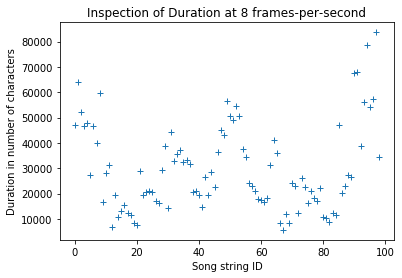

In [ ]:
#check the length of the different song in terms of number of character in the corresponding string.

plt.figure()
plt.plot([len(x) for x in music['text']],'+')
plt.xlabel('Song string ID')
plt.ylabel('Duration in number of characters')
plt.title('Inspection of Duration at 8 frames-per-second')
plt.show()

In [ ]:
# let's check the size of music dictionary in bytes

from sys import getsizeof

print(getsizeof(music))

240


In [ ]:
import pickle 

# let's define a function for saving the dictionary to disk

def save_obj(obj,filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        
# let's define a function for loading the dictionary from disk

def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [ ]:
# let's save the music dictionary

save_obj(music, 'music.pkl')